In [2]:
# Import pandas 
import pandas as pd

# Read in white wine data 
white = pd.read_csv('winequality-white.csv', sep=';')

# Read in red wine data 
red = pd.read_csv('winequality-red.csv', sep=';')

In [3]:
# Add `type` column to `red` with value 1
red['type'] = 1

# Add `type` column to `white` with value 0
white['type'] = 0

# Append `white` to `red`
#wines = red.append(white, ignore_index=True)
wines = pd.concat([red, white], ignore_index=True)

In [4]:
wines

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,0
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,0
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,0
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,0


In [5]:
X=wines.iloc[:,0:12]

In [6]:
X=wines.drop('quality',axis=1)

In [7]:
# Isolate target labels
#Y = wines.quality
import numpy as np 
Y=np.ravel(wines.quality)

In [8]:
# Import `StandardScaler` from `sklearn.preprocessing`
from sklearn.preprocessing import StandardScaler

# Scale
X_train=StandardScaler().fit_transform(X)

In [14]:
# Import `Sequential` from `keras.models`
from keras import Sequential

# Import `Dense` from `keras.layers`
from keras.layers import Dense
from keras.layers import Input
import keras

import numpy as np
from sklearn.model_selection import StratifiedKFold

seed = 140421
np.random.seed(seed)
keras.utils.set_random_seed(seed)

test = np.random.choice(X_train.shape[0], size=int(X_train.shape[0]*0.2), replace=False)
mse_vals = []
mae_vals = []

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
for train, val in kfold.split(X, Y):
    model = Sequential()
    model.add(Input(shape=(12, )))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    model.fit(X_train[train], Y[train], epochs=10,verbose=0)
    mse_aux_value, mae_aux_value=model.evaluate(X_train[val], Y[val], verbose=0)
    mse_vals.append(mse_aux_value)
    mae_vals.append(mae_aux_value)

mse_val_value = np.mean(mse_vals)
mae_val_value = np.mean(mae_vals)

#En caso de haber guardado un modelo...
y_test_pred = model.predict(X_train[test])
mse_test_value, mae_test_value=model.evaluate(X_train[test], Y[test], verbose=0)

print(f'Validation MSE: {mse_val_value:.5f}')
print(f'Validation MAE: {mae_val_value:.5f}')
print(f'Test MSE: {mse_test_value:.5f}')
print(f'Test MAE: {mae_test_value:.5f}') 


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Validation MSE: 0.52078
Validation MAE: 0.55884
Test MSE: 0.49805
Test MAE: 0.54303


In [15]:
from sklearn.metrics import r2_score
r2_score(Y[test],y_test_pred)

0.3586323857307434

# Experimentamos aumentar el número de iteraciones

In [9]:
# Import `Sequential` from `keras.models`
import os 
import polars as pl
import matplotlib.pyplot as plt
from keras import Sequential

# Import `Dense` from `keras.layers`
from keras.layers import Dense
from keras.layers import Input
import keras

import numpy as np
from sklearn.model_selection import StratifiedKFold

seed = 140421
np.random.seed(seed)
keras.utils.set_random_seed(seed)

test = np.random.choice(X_train.shape[0], size=int(X_train.shape[0]*0.2), replace=False)
mse_vals = []
mae_vals = []

k_folds = 5
kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=seed)
epochs = 50

def train_loop(
  epochs, 
  kfold,
  filename,
  layer_configs,
  logger_kwargs=None,
  compiler_kwargs=None
):
  if not logger_kwargs:
    logger_kwargs = {}
  default_compiler_kwargs = dict(optimizer="rmsprop", loss='mse', metrics=['mae'])
  if not compiler_kwargs:
    compiler_kwargs = {}
  default_compiler_kwargs = {**default_compiler_kwargs, **compiler_kwargs}
  # Keras callback to save the train error in each epoch
  if os.path.exists(filename):
    os.remove(filename)
  csv_logger = keras.callbacks.CSVLogger(filename, **logger_kwargs)
  for train, val in kfold.split(X, Y):
    model = Sequential()
    model.add(Input(shape=(12, )))
    for config in layer_configs:
      model.add(Dense(config, activation='relu'))
    model.add(Dense(1))
    model.compile(**default_compiler_kwargs, run_eargerly=True) # TODO: Review thos
    model.fit(
      X_train[train],
      Y[train],
      epochs=epochs,
      verbose=0,
      callbacks=[csv_logger],
      validation_data=(X_train[val], Y[val]),
    )
  # Ojo: Solo estamos devolviendo el último modelo de validación, no el mejor.
  return model

In [21]:
filename = "epochs_logger.csv"
model = train_loop(epochs=epochs, kfold=kfold, filename=filename, layer_configs=[64], logger_kwargs={"append": True})

KeyboardInterrupt: 

In [60]:
def read_dataframe(filename):
  train_df = pl.read_csv(filename)
  train_df = train_df.with_columns(pl.lit([k for _ in range(epochs) for k in range(k_folds)]).alias("k_fold"))
  return train_df

train_df = read_dataframe(filename)

def read_test_results(model):
  mse_test_value, mae_test_value = model.evaluate(
    X_train[test],
    Y[test],
    verbose=0
  )
  return mse_test_value, mae_test_value

def get_results(train_df, model,):
  mse_val_value = train_df["val_loss"].mean()
  mae_val_value = train_df["val_mae"].mean()

  mse_test_value, mae_test_value = read_test_results(model,)

  return mse_val_value, mae_val_value, mse_test_value, mae_test_value

def print_results(mse_val_value, mae_val_value, mse_test_value, mae_test_value):
  print(f'Validation MSE: {mse_val_value:.5f}', end="\t")
  print(f'Validation MAE: {mae_val_value:.5f}')
  print(f'Test MSE: {mse_test_value:.5f}', end="\t")
  print(f'Test MAE: {mae_test_value:.5f}') 

print_results(*get_results(train_df, model))

Validation MSE: 0.56394	Validation MAE: 0.57469
Test MSE: 0.45267	Test MAE: 0.51947


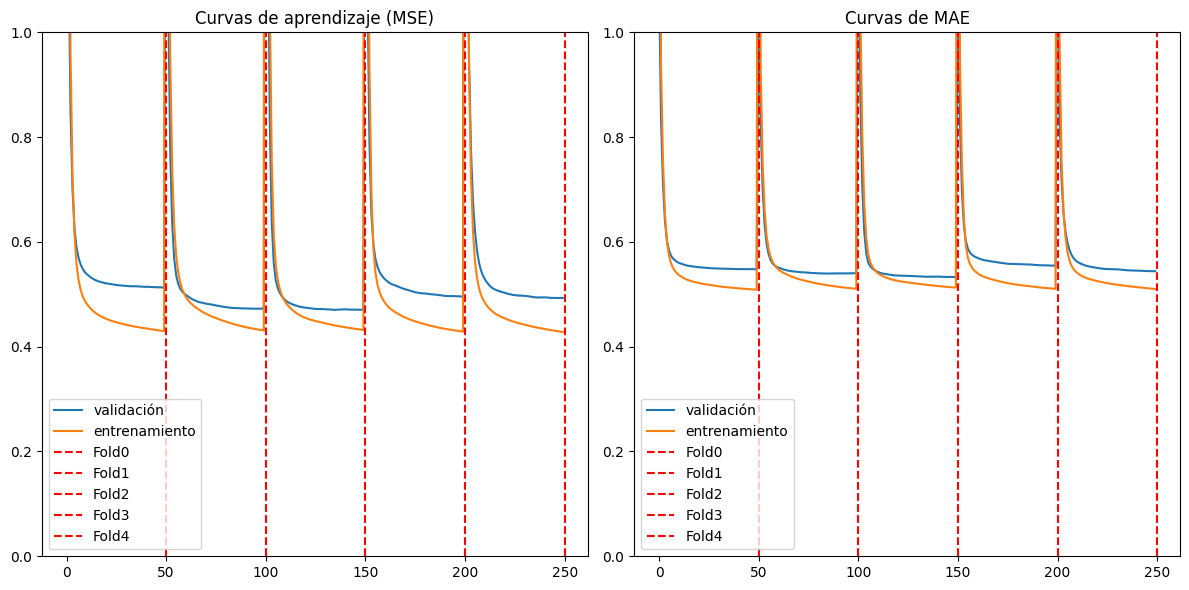

In [61]:
def plot_training_curves(train_df,):
  fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(12, 6))
  mse_train, mse_vals = train_df["loss"].to_list(), train_df["val_loss"].to_list()
  mae_train, mae_vals = train_df["mae"].to_list(), train_df["val_mae"].to_list()
  length = range(epochs * k_folds)
  ax[0].plot(length, mse_vals, label="validación")
  ax[0].plot(length, mse_train, label="entrenamiento")
  for k in range(k_folds):
    ax[0].axvline(x=epochs * (k+1), label=f"Fold{k}", color = "red", linestyle="dashed")
  ax[0].set_title("Curvas de aprendizaje (MSE)")
  ax[0].set_ylim((0, 1.0))
  ax[0].legend()
  ax[1].plot(length, mae_vals, label="validación")
  ax[1].plot(length, mae_train, label="entrenamiento")
  for k in range(k_folds):
    ax[1].axvline(x=epochs * (k+1), label=f"Fold{k}", color = "red", linestyle="dashed")
  ax[1].set_title("Curvas de MAE")
  ax[1].set_ylim((0, 1.0))
  ax[1].legend()
  return fig, ax

fig, ax = plot_training_curves(train_df)
plt.show()

En la Figura anterior observamos el comportamiento de las curvas de aprendizaje de nuestro modelo para los diferentes pliegues de validación. Notamos que a medida que crece el número de iteraciones la distancia entre la curva de aprendizaje de entrenamiento y la de validación aumenta. Es decir, nuestro modelo empezaría a sobre-entrenar dado que empieza a aprender rasgos de nuestros datos de entrenamiento que no tienen porque generalizar bien. Es un comportamiento similar a lo que observamos en la práctica anterior al aumentar la complejidad del modelo. Ambos hechos pueden llegar a producir el mismo efecto. Es necesario tomar medidas de regularización para controlar la capacidad de generalización del modelo ("Bias and Variance Trade-off").

# Experimentamos agregar más capas

A sabiendas del anterior, vamos a probar aumentar el número de capas ocultas manteniendo el número de unidades y observando el promedio de clasificación de validación. Sabemos, que si ocurre sobre-entrenamiento, de forma similar a lo visto anteriormente, dicho error de validación crecerá. Esperamos observamos el comportamiento

In [66]:
layer_configs = [[64, 64], [64, 64, 64], [64, 64, 64, 64]]
if not os.path.exists("csvs/"):
  os.mkdir("csvs/")
filename = "csvs/layers.csv"
mse_val, mae_val = [], []
for layer_config in layer_configs:
  model = train_loop(epochs=10, kfold=kfold, filename=filename, layer_configs=layer_config, logger_kwargs={"append": False})
  train_df = read_dataframe(filename)
  results = get_results(train_df=train_df, model=model)
  mse_val.append(results[0])
  mae_val.append(results[1])

In [67]:
df = pl.DataFrame({"mse": mse_val, "mae": mae_val, "config": [len(layer_config) for layer_config in layer_configs]})
df 

mse,mae,config
f64,f64,i64
0.770504,0.656313,2
0.696088,0.629152,3
0.707293,0.634171,4


Efectivamente, observamos que al incrementar el número de capas ocultas con 64 unidades de 2 a 4 la capacidad de generalización disminuye. 

# Observar el comportamiento de la tasa de aprendizaje

In [14]:
from keras.optimizers import RMSprop 
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
# tf.compat.v2.enable_v2_behavior()
opt = RMSprop(learning_rate=0.0001)
compiler_kwargs = dict(optimizer=opt)
filename = "csvs/learning_rate.csv"
model = train_loop(epochs=1, kfold=kfold, filename=filename, logger_kwargs={"append": False}, compiler_kwargs=compiler_kwargs, layer_configs=[64])
train_df = read_dataframe(filename)
plot_training_curves(train_df)

NotImplementedError: numpy() is only available when eager execution is enabled.

In [75]:
from keras.optimizers import RMSprop
compiler_kwargs = dict(optimizer=RMSprop(learning_rate=10.0))
filename = "csvs/learning_rate.csv"
model = train_loop(epochs=10, kfold=kfold, filename=filename, logger_kwargs={"append": False}, compiler_kwargs=compiler_kwargs, layer_configs=[64])
train_df = read_dataframe(filename)
plot_training_curves(train_df)

NotImplementedError: numpy() is only available when eager execution is enabled.

In [28]:
# Import `Sequential` from `keras.models`
from keras import Sequential

# Import `Dense` from `keras.layers`
from keras.layers import Dense

import numpy as np
from sklearn.model_selection import StratifiedKFold


from keras.optimizers import RMSprop


rmsprop=RMSprop(learning_rate=0.0001)
seed = 7
np.random.seed(seed)

test = np.random.choice(X_train.shape[0], size=int(X_train.shape[0]*0.2), replace=False)
mse_vals = []
mae_vals = []

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
for train, val in kfold.split(X, Y):
    model = Sequential()
    model.add(Dense(128, input_dim=12, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    model.fit(X_train[train], Y[train], epochs=10,verbose=0)
    mse_aux_value, mae_aux_value=model.evaluate(X_train[val], Y[val], verbose=0)
    mse_vals.append(mse_aux_value)
    mae_vals.append(mae_aux_value)

mse_val_value = np.mean(mse_vals)
mae_val_value = np.mean(mae_vals)

#En caso de haber guardado un modelo...
y_test_pred = model.predict(X_train[test])
mse_test_value, mae_test_value=model.evaluate(X_train[test], Y[test], verbose=0)

print(f'Validation MSE: {mse_val_value:.5f}')
print(f'Validation MAE: {mae_val_value:.5f}')
print(f'Test MSE: {mse_test_value:.5f}')
print(f'Test MAE: {mae_test_value:.5f}') 




41/41 [==============================] - 0s 985us/step
Validation MSE: 0.50162
Validation MAE: 0.54699
Test MSE: 0.45020
Test MAE: 0.51646


In [29]:
# Import `Sequential` from `keras.models`
from keras import Sequential

# Import `Dense` from `keras.layers`
from keras.layers import Dense

import numpy as np
from sklearn.model_selection import StratifiedKFold

from keras.optimizers import SGD, RMSprop


sgd=SGD(learning_rate=0.1)
seed = 7
np.random.seed(seed)



test = np.random.choice(X_train.shape[0], size=int(X_train.shape[0]*0.2), replace=False)
mse_vals = []
mae_vals = []

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
for train, val in kfold.split(X, Y):
    model = Sequential()
    model.add(Dense(128, input_dim=12, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    model.fit(X_train[train], Y[train], epochs=10,verbose=0)
    mse_aux_value, mae_aux_value=model.evaluate(X_train[val], Y[val], verbose=0)
    mse_vals.append(mse_aux_value)
    mae_vals.append(mae_aux_value)

mse_val_value = np.mean(mse_vals)
mae_val_value = np.mean(mae_vals)

#En caso de haber guardado un modelo...
y_test_pred = model.predict(X_train[test])
mse_test_value, mae_test_value=model.evaluate(X_train[test], Y[test], verbose=0)

print(f'Validation MSE: {mse_val_value:.5f}')
print(f'Validation MAE: {mae_val_value:.5f}')
print(f'Test MSE: {mse_test_value:.5f}')
print(f'Test MAE: {mae_test_value:.5f}') 




41/41 [==============================] - 0s 749us/step
Validation MSE: 0.50306
Validation MAE: 0.54755
Test MSE: 0.46668
Test MAE: 0.52462


In [34]:
from keras.optimizers import SGD, RMSprop


sgd=SGD(learning_rate=0.1)
seed = 7
np.random.seed(seed)

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
for train, test in kfold.split(X, Y):
    model2 = Sequential()
    model2.add(Dense(128, input_dim=12, activation='relu'))
    model2.add(Dense(1))
    model2.compile(optimizer='sgd', loss='mse', metrics=['mae'])
    model2.fit(X_train[train], Y[train], epochs=10,verbose=0)
    y_pred=model.predict(X_train[test])




mse_value, mae_value=model.evaluate(X_train[test], Y[test], verbose=0)

print(mse_value)

41/41 [==============================] - 0s 641us/step
33.53929901123047


In [35]:
from keras.optimizers import SGD, RMSprop


sgd=SGD(learning_rate=0.1)
seed = 7
np.random.seed(seed)

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
for train, test in kfold.split(X, Y):
    model = Sequential()
    model.add(Dense(64, input_dim=12, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='sgd', loss='mse', metrics=['mae'])
    model.fit(X_train[train], Y[train], epochs=10,verbose=0)
    y_pred=model.predict(X_train[test])
mse_value, mae_value=model.evaluate(X_train[test], Y[test], verbose=0)
print(mse_value)

41/41 [==============================] - 0s 791us/step
0.5123742818832397
